In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown
import pandas as pd
import altair as alt
import re
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results
from benchmarks.overhead_latency import echo

InteractiveShell.ast_node_interactivity = "all"

In [2]:
benchmark_results = get_benchmark_results()


## ipyparallel benchmark results ##

In [42]:
datasource = {}
nodelay_source = {'Duration in ms': [], 'Number of tasks': [], 'Number of cores': []}
throughput_source = {}
for machine_name, benchmark_run in benchmark_results.items():
    number_of_cores = int(re.findall('\d+', machine_name)[0])
    for benchmark_name, results in benchmark_run.results_dict.items():
        if not 'time_n_tasks' in benchmark_name or 'NoDelay' in benchmark_name:
            continue
        number_of_engines = re.findall('\d+', benchmark_name)[0]
        for duration, tasks_num, delay in\
            [(result.duration_in_ms, result.number_of_tasks, seconds_to_ms(result.delay)) for result in results if not result.failed]:
            if not delay in datasource:
                datasource[delay] = {number_of_cores:  { 'Duration in ms': [], 'Number of tasks': [], 'Number of engines': [] }}
            if not number_of_cores in datasource[delay]:
                datasource[delay][number_of_cores] = { 'Duration in ms': [], 'Number of tasks': [], 'Number of engines': [] }
                
            datasource[delay][number_of_cores]['Duration in ms'].append(duration)
            datasource[delay][number_of_cores]['Number of tasks'].append(tasks_num)
            datasource[delay][number_of_cores]['Number of engines'].append(number_of_engines)
    for result in benchmark_run.results_dict['overhead_latency.Engines100NoDelay.time_n_tasks']:
        if result.failed:
            continue
        nodelay_source['Duration in ms'].append(result.duration_in_ms)
        nodelay_source['Number of tasks'].append(result.number_of_tasks)
        nodelay_source['Number of cores'].append(number_of_cores)
    throughput_source[number_of_cores] = {'Number of engines': [], 'Number of bytes': [], 'Duration in ms': []}
    for result in benchmark_run.results_dict['throughput.NumpyArrayBroadcast.time_broadcast']:
        if result.failed:
            continue
        throughput_source[number_of_cores]['Duration in ms'].append(result.duration_in_ms)
        throughput_source[number_of_cores]['Number of bytes'].append(result.number_of_bytes)
        throughput_source[number_of_cores]['Number of engines'].append(result.number_of_engines)
        

### time_n_tasks ###
The first benchmark comes from benchmarking the runtime of sending
n tasks to m engines. Where the each task is just the echo function. 

In [33]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/overhead_latency.py
Type:      function


### With a delay of 0.0s. :

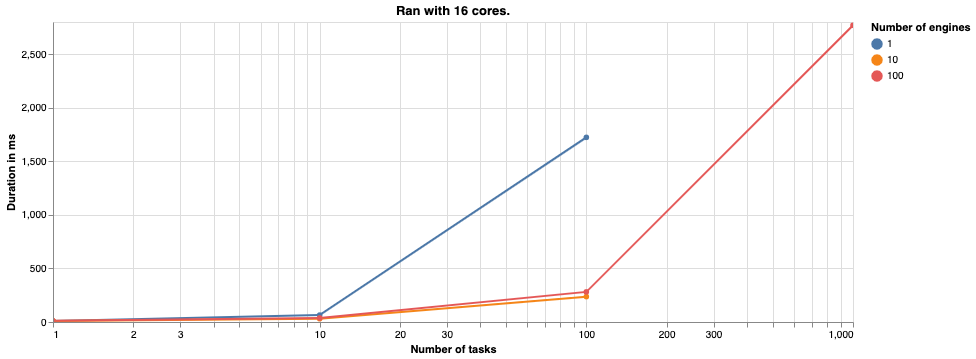

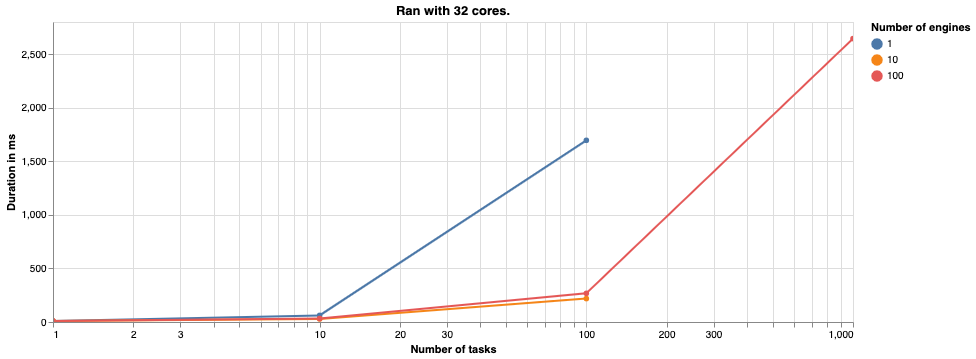

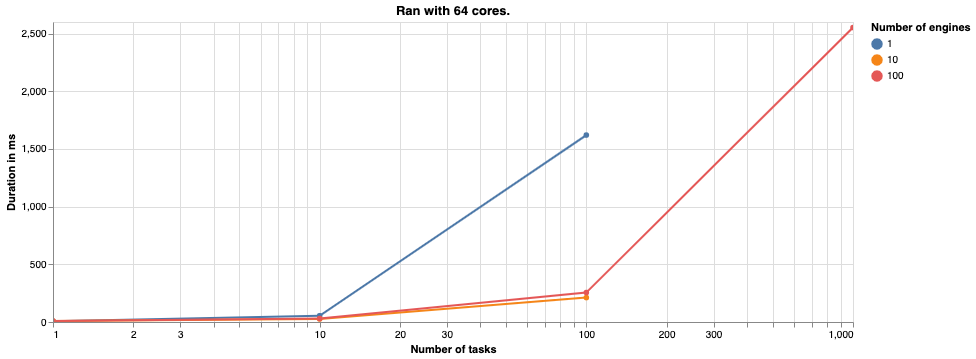

### With a delay of 0.1s. :

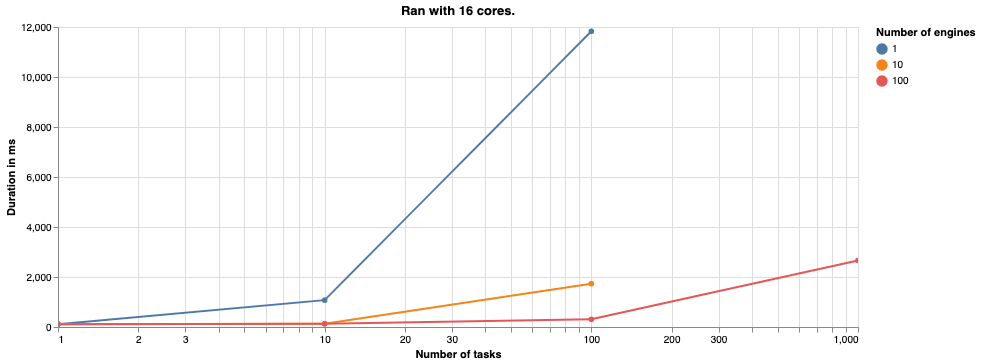

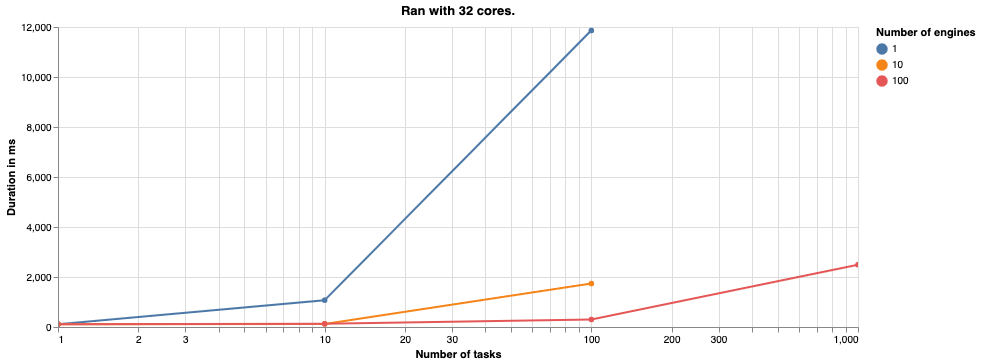

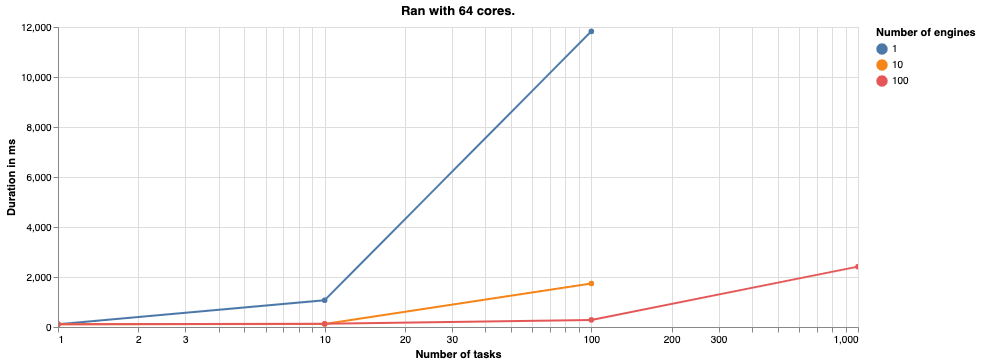

### With a delay of 1.0s. :

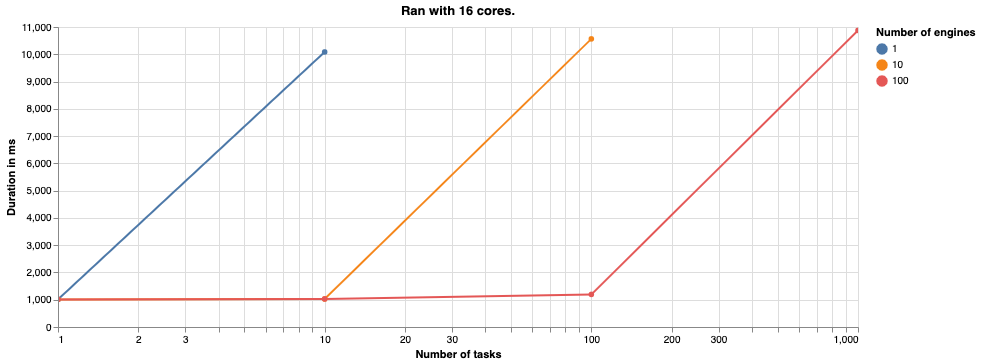

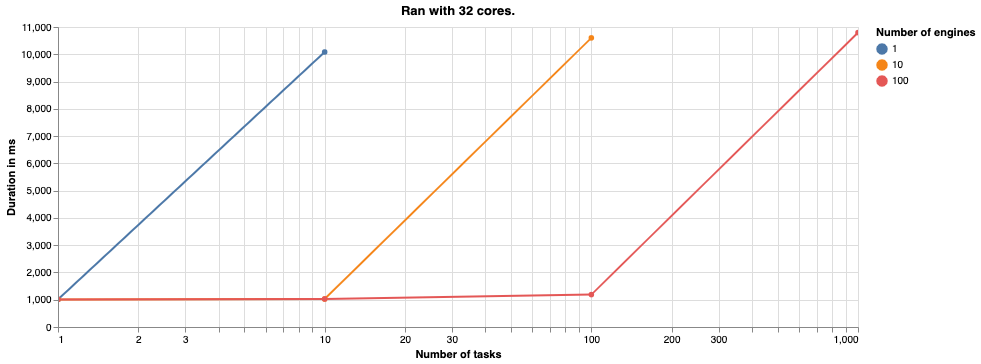

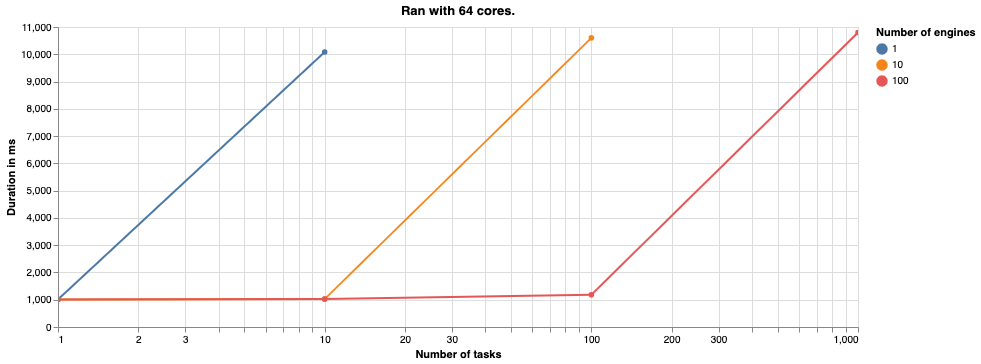

In [21]:
for delay, result_for_delay in datasource.items():
    display(Markdown(f'### With a delay of {ms_to_seconds(delay)}s. :'))
    for core_num, results in sorted(result_for_delay.items(), key=lambda key: key[0]):            
        data = pd.DataFrame(results)
        alt.Chart(data).mark_line(point=True).encode(
            alt.X(
                'Number of tasks',
                scale=alt.Scale(type='log')
            ),
            y='Duration in ms',
            color='Number of engines:N',
            tooltip='Duration in ms'            
        ).properties(
            title=f'Ran with {core_num} cores.',
            width=800
        ).interactive().display(renderer='svg')
      

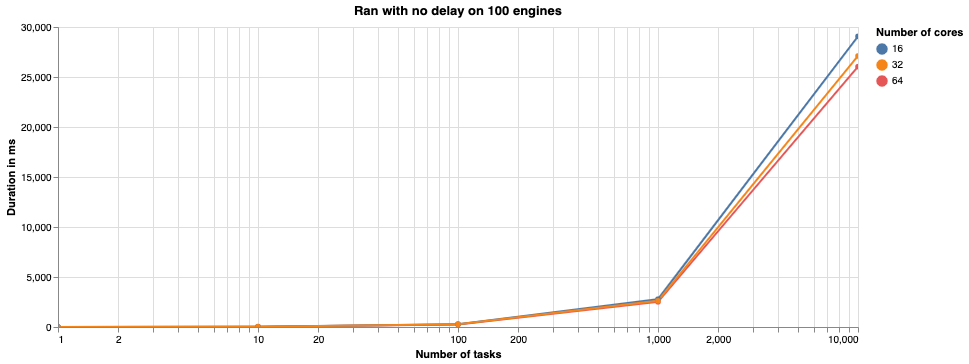

In [44]:
data = pd.DataFrame(nodelay_source)
alt.Chart(data).mark_line(point=True).encode(
    alt.X(
        'Number of tasks',
        scale=alt.Scale(type='log')
    ),
    color='Number of cores:N',
    y='Duration in ms',
    tooltip='Duration in ms',                         
).properties(title=f'Ran with no delay on 100 engines', width=800).interactive().display(renderer='svg')

### time_broadcast ###
The second benchmark comes from benchmarking the runtime of sending
and array of n bytes to m engines. 

In [12]:
from benchmarks.throughput import NumpyArrayBroadcast
NumpyArrayBroadcast.time_broadcast??

Signature: NumpyArrayBroadcast.time_broadcast(self, engines, numBytes)
Docstring: <no docstring>
Source:   
    def time_broadcast(self, engines, numBytes):
        self.client[:engines]["x"] = np.array([0] * numBytes, dtype=np.int8)
File:      ~/ipyparallel_master_project/benchmarks/throughput.py
Type:      function


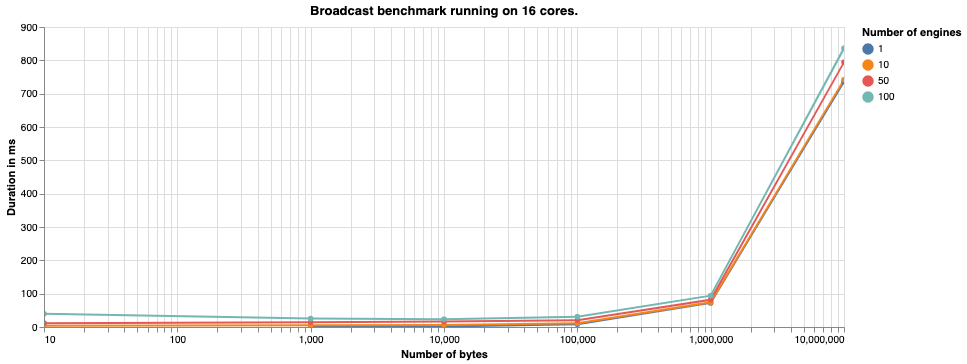

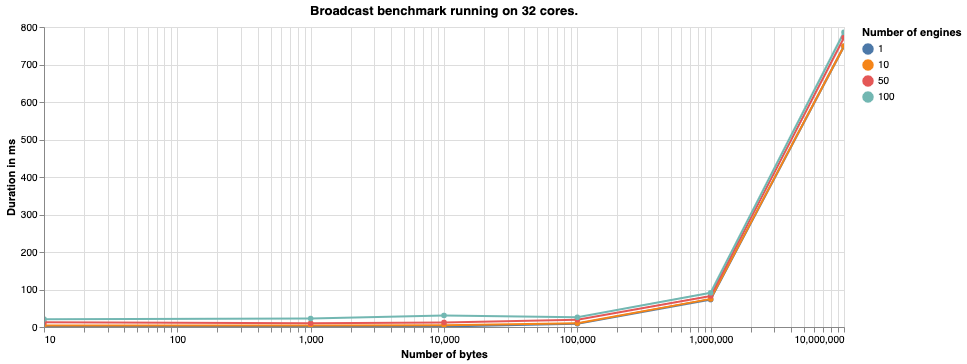

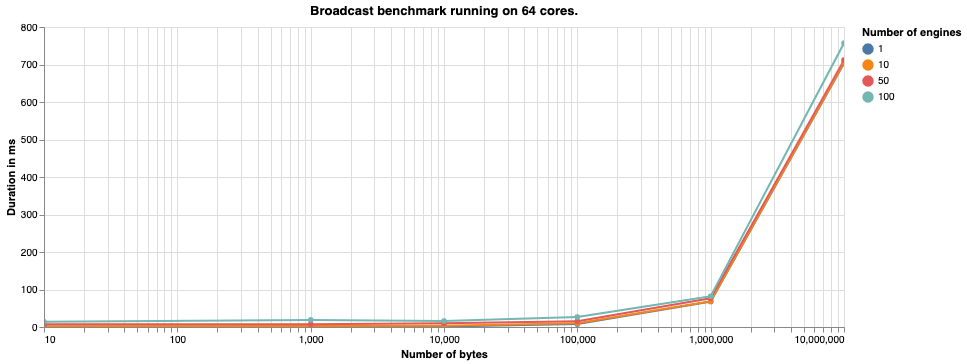

In [24]:
for core_num, results in sorted(throughput_source.items(), key=lambda key: key[0]):
    data = pd.DataFrame(results)
    alt.Chart(data).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        y='Duration in ms',
        color='Number of engines:N',
        tooltip='Duration in ms',                         
    ).properties(title=f'Broadcast benchmark running on {core_num} cores.', width=800).interactive().display(renderer='svg')